Ноутбук должен запускаться из директории, содержащей read_data.py, svd.py, eval_metrics.py .

Создает два csv для каждого кластера, один с set_id, другой с user_id 

In [1]:
from read_data import read_data, train_test, user_item_matrix
from svd import Recommender, MostPopularRecommender, filter_new, convert_to_recsys_data
from eval_metrics import top_n, apk
import numpy as np
import seaborn as sns
from pandas.tseries.offsets import *
from pandas.compat import u
import csv
%matplotlib inline

Читаем тренировочные и тестовые данные. Тестовые данные - последний месяц. Активными считаются сеты, которые продаались хотя бы один раз за месяц до начала теста. До разбиения проводится отождествление наследников, выкидываются бесплатные наборы.

In [2]:
train, test = train_test(read_data("../../input/", filename="orders_items_registrations.csv"), 
                         test_size=DateOffset(months=0, days=30),  sales_end_offset=DateOffset(months=0, days=15))

Active sets: 38
Test size: 1121 Train size 14535


Удаляем из тестового датасета пользователей, не встречающихся в тренировочном

In [55]:
test = filter_new(train, test)

Users: 6242


Конвертируем датафреймы в формат, понимаемый recsys. Так же сохраняем user_idы пользователей.

In [56]:
user_ids = train["user_id"].unique()
train = convert_to_recsys_data(train)
test = convert_to_recsys_data(test)

Оцениваем эффективность рекомендаций для разных k и пропорций сетов из свд и топа в рекомендации. 

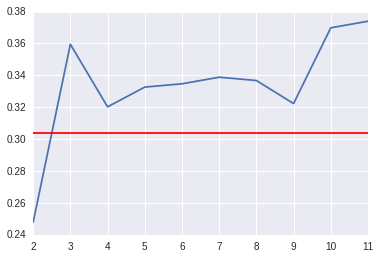

In [67]:
k_list = list(range(2, 12))
acc = []
most_pop = []
mrec = MostPopularRecommender(train, count=6)

for k in k_list:
    rec = Recommender(data=train, k=k, most_pop_count=6) # most_pop_count - length of inner list of most popular items
    acc.append(rec.eval_on_clusters(test, from_svd=5, from_top=1, metric=top_n))
    
sns.plt.plot(k_list, acc)
sns.plt.plot(k_list, [mrec.evaluate(test, metric=top_n) for i in k_list], color="r")
sns.plt.show()

Создаем svd-рекомендатор с заданным числом сегментов.

In [71]:
rec = Recommender(train, k=3, most_pop_count=6)

Получаем dict вида {cluster_id: {"set_ids":[], "user_ids": []}}

In [72]:
cluster_dict = rec.top_svd_mixed_clusters(from_svd=5, from_top=1)

Записываем его в csvшки

In [75]:
for cluster in cluster_dict:
    with open('output/' + 'svd_users_' + str(cluster) + '.csv', 'wb') as csvfile:
        writer = csv.writer(csvfile, delimiter=',')
        writer.writerow(["user_id"])
        for user_id in cluster_dict[cluster]["user_ids"]:
            writer.writerow([user_id])

    with open('output/' + 'svd_sets_' + str(cluster) + '.csv', 'wb') as csvfile:
        writer = csv.writer(csvfile, delimiter=',')
        writer.writerow(["set_id"])
        for set_id in cluster_dict[cluster]["set_ids"]:
            writer.writerow([set_id])

Содержимое кластеров сетов:

In [76]:
train, test = train_test(read_data("../../input/"), test_size=DateOffset(months=0, days=30),
                         sales_end_offset=DateOffset(months=0, days=15))
test = filter_new(train, test)
train = convert_to_recsys_data(train)
test = convert_to_recsys_data(test)
rec = Recommender(train, k=3, most_pop_count=6)
print MostPopularRecommender(train, count=6).most_popular[:6]

clusters = rec.top_svd_mixed_clusters(from_svd=5, from_top=1)
train, test = train_test(read_data("../../input/"), test_size=DateOffset(months=0, days=30), 
                         sales_end_offset=DateOffset(months=0, days=15))
id_names = {}
for cluster in clusters:
    print clusters[cluster]["set_ids"]
    id_names[cluster] = []
    for row in train.iterrows():
        if row[1]["set_id"] in clusters[cluster]["set_ids"] and row[1]["set_title"] not in id_names[cluster]:
            id_names[cluster].append(row[1]["set_title"].split(" v.")[0].strip())
            clusters[cluster]["set_ids"].pop(clusters[cluster]["set_ids"].index(row[1]["set_id"]))
id_names = {i: list(set(id_names[i])) for i in id_names}
    
    
for i in clusters:
    print u'[' + u','.join(id_names[i]) + u']'

Active sets: 38
Test size: 1121 Train size 14535
Users: 6242
[526, 527, 513, 273, 549, 535]
Active sets: 38
Test size: 1121 Train size 14535
[526, 520, 519, 522, 521, 410]
[526, 494, 451, 545, 273, 461]
[513, 527, 526, 494, 535, 537]
[Пара идеальных бокалов,Пятничный красный,Red Starter,Бутылка шампанского Serge Mathieu,Пятничный белый,Пятничный игристый]
[Red Starter,Ящик Prosecco Ca' del Dodge,Drink Pink,Теплый клетчатый сет,Girls Set,Ящик Barista Pinotage]
[Mixed Starter,Red Explorer,White Starter,Red Starter,Ящик Prosecco Ca' del Dodge,Бюджетный сет]


In [3]:
sets_1 = [527, 526, 513, 547, 451, 549]
sets = sets_1

In [7]:
train.query('set_id in @sets')['set_title'].unique()

array([u'Red Starter', u'Mixed Starter', u'Red Advanced',
       u'Red Starter v.2', u'Red Explorer', u'Red Advanced v.2',
       u'Red Starter v.3.0', u'Mixed Starter v.3', u'Red Explorer v.2',
       u'Red Starter v.3', u'Meat the Wine', u'Mixed Starter v.4.0',
       u'Red Starter v.4.0', u'Red Explorer v.3', u'Mixed Starter v.4',
       u'Red Starter v.4', u'Meat the Wine v.2.1', u'Red Advanced v.3',
       u'\u042f\u0449\u0438\u043a Barista Pinotage', u'Red Starter v.4.1',
       u'\u042f\u0449\u0438\u043a Barista Pinotage v.1.1',
       u'Meat the Wine v.1.1', u'Red Explorer v.3.1', u'Red Starter v.5',
       u'Red Explorer v.4', u'Mixed Starter v.5', u'Red Advanced v.4',
       u'Red Starter v.6.1', u'Red Advanced v.5', u'Red Explorer v.5',
       u'Mixed Starter v.6', u'Meat the Wine v.3.1', u'Red Starter v.7',
       u'Red Explorer v.6', u'Mixed Starter v.7', u'Red Advanced v.6',
       u'Meat the Wine v.3.2', u'Mixed Starter v.8', u'Red Starter v.8',
       u'Red Advanced v.7

In [8]:
train.query('set_id == 527')['set_title'].unique()

array([u'Mixed Starter', u'Mixed Starter v.3', u'Mixed Starter v.4.0',
       u'Mixed Starter v.4', u'Mixed Starter v.5', u'Mixed Starter v.6',
       u'Mixed Starter v.7', u'Mixed Starter v.8', u'Mixed Starter v.9',
       u'Mixed Starter v.9.1', u'Mixed Starter v.10',
       u'Mixed Starter v.10.1', u'Mixed Starter v.10.2',
       u'Mixed Starter v.10.3', u'Mixed Starter v.10.4',
       u'Mixed Starter v.11'], dtype=object)

In [9]:
train.query('set_id == 527')

order_id  user_id          order_date     fulfilment_date  \
606         620      525 2013-09-21 10:44:12 2013-09-23 18:29:53   
617         629       27 2013-09-28 20:21:12 2013-09-29 20:21:12   
630         639     2811 2013-10-03 19:18:44 2013-10-04 19:18:44   
665         696     1998 2013-10-25 05:42:30 2013-10-26 05:42:30   
679         708     1008 2013-10-31 08:51:44 2013-11-01 08:51:44   
685         714     2979 2013-10-31 18:41:07 2013-11-01 18:41:07   
703         732     1966 2013-11-06 11:50:40 2013-11-11 07:00:14   
709         736     2116 2013-11-07 09:23:39 2013-11-11 07:10:04   
710         737     1179 2013-11-07 11:33:03 2013-11-11 07:10:05   
714         741     3108 2013-11-08 19:26:31 2013-11-10 08:10:02   
717         744      390 2013-11-10 19:51:46 2013-11-13 11:50:04   
719         747      740 2013-11-11 09:07:04 2013-11-12 12:10:04   
724         751     1111 2013-11-11 09:43:11 2013-11-13 11:40:03   
730         757     4895 2013-11-12 07:57:45 2014-02-03 12:10:02   
735         761     1539 2013-11-13 19:45:43 2013-11-14 09:30:03   
737         763     1862 2013-11-14 08:47:55 2013-11-19 07:50:06   
740         766      390 2013-11-15 07:24:15 2013-11-16 10:50:02   
747         771     2370 2013-11-18 10:26:59 2013-11-19 07:50:05   
757         781     4796 2013-11-22 09:52:24 2013-11-22 13:30:03   
771         793     2916 2013-11-28 12:44:01 2013-11-29 15:10:04   
782         804      713 2013-11-30 09:56:10 2013-12-05 08:30:07   
787         810      463 2013-12-02 09:37:33 2013-12-03 09:50:03   
792         814     1240 2013-12-03 07:37:26 2013-12-04 08:20:06   
799         821     5010 2013-12-04 10:59:40 2013-12-06 10:10:05   
806         828     4963 2013-12-05 15:33:40 2013-12-11 07:10:04   
810         831     3139 2013-12-05 17:59:50 2013-12-07 11:50:04   
811         832     5034 2013-12-05 19:20:45 2013-12-08 15:30:04   
817         836     4333 2013-12-05 21:38:34 2013-12-09 06:50:06   
824         842     5047 2013-12-06 13:07:54 2013-12-09 11:30:06   
830         847     5069 2013-12-08 01:54:20 2013-12-17 08:00:07   
...         ...      ...                 ...                 ...   
32985     20956      399 2016-05-24 09:42:18                 NaT   
32993     20960    12885 2016-05-24 10:19:10 2016-05-24 15:40:06   
33000     20963    28334 2016-05-24 11:27:25 2016-05-24 15:40:06   
33004     20965    34090 2016-05-24 12:01:22 2016-05-24 15:00:06   
33018     20973    31493 2016-05-24 15:44:19 2016-05-25 10:13:29   
33025     20977    49955 2016-05-24 17:50:27 2016-05-25 10:50:04   
33064     20993    46278 2016-05-25 11:07:12 2016-05-26 11:00:05   
33066     20994    48031 2016-05-25 11:56:05 2016-05-25 15:30:06   
33077     21001    49923 2016-05-25 14:28:26 2016-05-26 10:05:48   
33089     21008    37745 2016-05-25 17:23:40 2016-05-26 12:10:04   
33104     21015    20052 2016-05-25 20:20:51 2016-05-26 12:20:05   
33151     21040     7653 2016-05-26 12:44:55 2016-05-27 13:30:05   
33164     21045    15130 2016-05-26 13:13:26 2016-05-27 09:30:05   
33183     21056    31939 2016-05-26 15:52:50 2016-05-27 09:50:04   
33193     21061     7115 2016-05-26 18:37:10 2016-05-27 14:20:05   
33210     21071    50078 2016-05-27 08:15:56 2016-05-27 11:50:05   
33219     21078    36571 2016-05-27 10:50:52 2016-05-31 15:40:04   
33235     21089    45803 2016-05-27 14:21:48 2016-05-28 07:20:04   
33241     21092    50073 2016-05-27 17:14:45 2016-06-04 08:30:05   
33244     21094    49376 2016-05-27 20:52:28 2016-05-28 11:30:04   
33279     21110     7200 2016-05-29 08:37:34 2016-05-30 09:30:03   
33292     21117    24645 2016-05-29 20:10:17 2016-05-30 12:40:04   
33325     21135    36571 2016-05-30 15:15:31 2016-06-11 09:40:04   
33393     21177     7724 2016-05-31 15:11:58 2016-06-02 07:40:05   
33414     21190    50522 2016-05-31 17:53:55 2016-06-02 12:30:08   
33529     21266    50692 2016-06-01 16:57:34 2016-06-08 07:40:05   
33540     21274    48417 2016-06-01 19:17:26 2016-06-03 07:10:0